In [51]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap 

from six import StringIO
from IPython.display import Image, display
import pydotplus

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, \
                            brier_score_loss, classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, GridSearchCV, StratifiedKFold, RandomizedSearchCV

from scipy import stats

import xgboost

pd.options.display.max_columns = None
pd.options.display.max_rows = None

seed = 1984

# Objective

To identify the clients which will not perfom well, I will: 

- **Feature selection**<br> 
    - Train an inital estimator to use Recursive Feature elimination and select only the most important features, and compare to a Logistic Regression model with L1 penalty.   
    - Train a Decision Tree model to use as a descriptive model, and see what are some of the rules that split the data, as well as confirm the results obtained in the previous step.


- **Model training**<br>
    Using the features obtained from the previous step, train a classification model, and with it identify the most significant features in it: 
 
    - Train two classification models (*XGBoost, Random Forest*), choose the one that fits better and, from the selected model, then see the SHAP values for the features to understand how they affect the prediction, in this case focusing on the poorly performing applicants. 

# Load data

In [2]:
path = str(Path().resolve().parent) + '\\data\\'
applications_approved = pd.read_csv(path + '/approved_application_data.csv')

# Feature Engineering

In [43]:
# some states have too few observations. I will group these into the category "other"
applications_approved['state'] = np.where(applications_approved['state'].isin(['"ID"', '"KS"', '"GA"', '"FL"']), 
                                                                             'other', 
                                                                             applications_approved['state'])

# Feature selection

I will not use the *'loan_amout'* feature, as I assume this is the amount actually granted as a loan, and it would mean leaking data. 

In [45]:
# Split into X and y to then split into train and test
X = applications_approved.loc[:,~applications_approved.columns.isin(['Unnamed: 0','loan_amount', 'status'])]
X = pd.get_dummies(X)
y = applications_approved.loc[:,'status']

## Linear Support Vector Classifier

In this case, the parameter *C* controls the sparsity: the smaller C the fewer features selected. 

In [46]:
lsvc = LogisticRegression(C=0.001, penalty="l1", solver='liblinear', 
                          max_iter=2000, random_state = seed).fit(X, y) 
model_svc = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)
X_new.shape

ValueError: X has a different shape than during fitting.

In [47]:
cols_del_SVC = pd.DataFrame({'col': X.columns, 'keep' : model_svc.get_support()})
cols_del_SVC

,col,keep
0,monthly_income,True
1,gig_economy_weekly_income,False
2,atm_check_deposits_weekly_income,False
3,direct_deposit_weekly_income,True
4,government_aid_weekly_income,False
5,frequency_heuristic_weekly_income,False
6,large_deposits_weekly_income,True
7,income_length,True
8,payrolls_per_month,False
9,income_sources,False


## Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
clf = RandomForestClassifier(n_estimators=50, random_state = seed)
clf = clf.fit(X, y) 
model = SelectFromModel(clf, prefit=True, threshold = 'median')
X_new = model.transform(X)
X_new.shape

(4145, 18)

In [49]:
cols_del_rf = pd.DataFrame({'col': X.columns, 'keep' : model.get_support()})
cols_del_rf

,col,keep
0,monthly_income,True
1,gig_economy_weekly_income,False
2,atm_check_deposits_weekly_income,True
3,direct_deposit_weekly_income,True
4,government_aid_weekly_income,False
5,frequency_heuristic_weekly_income,True
6,large_deposits_weekly_income,False
7,income_length,True
8,payrolls_per_month,True
9,income_sources,True


After comparing both feature selections, I decided to keep the features selected by the Random Forest estimator, as it seems most consistent with what was seen in the EDA. A lot of the features that were dropped had most of their values at zero, and thus are not very relevant. 

Even though the selector is dropping most of the features related to other types of loans, it's retaining no_of_other_active_loans, which could summarize the information contained in the other features it's dropping.

## Decision Tree

As this model is only intended to be descriptive, I will use all of the X values.

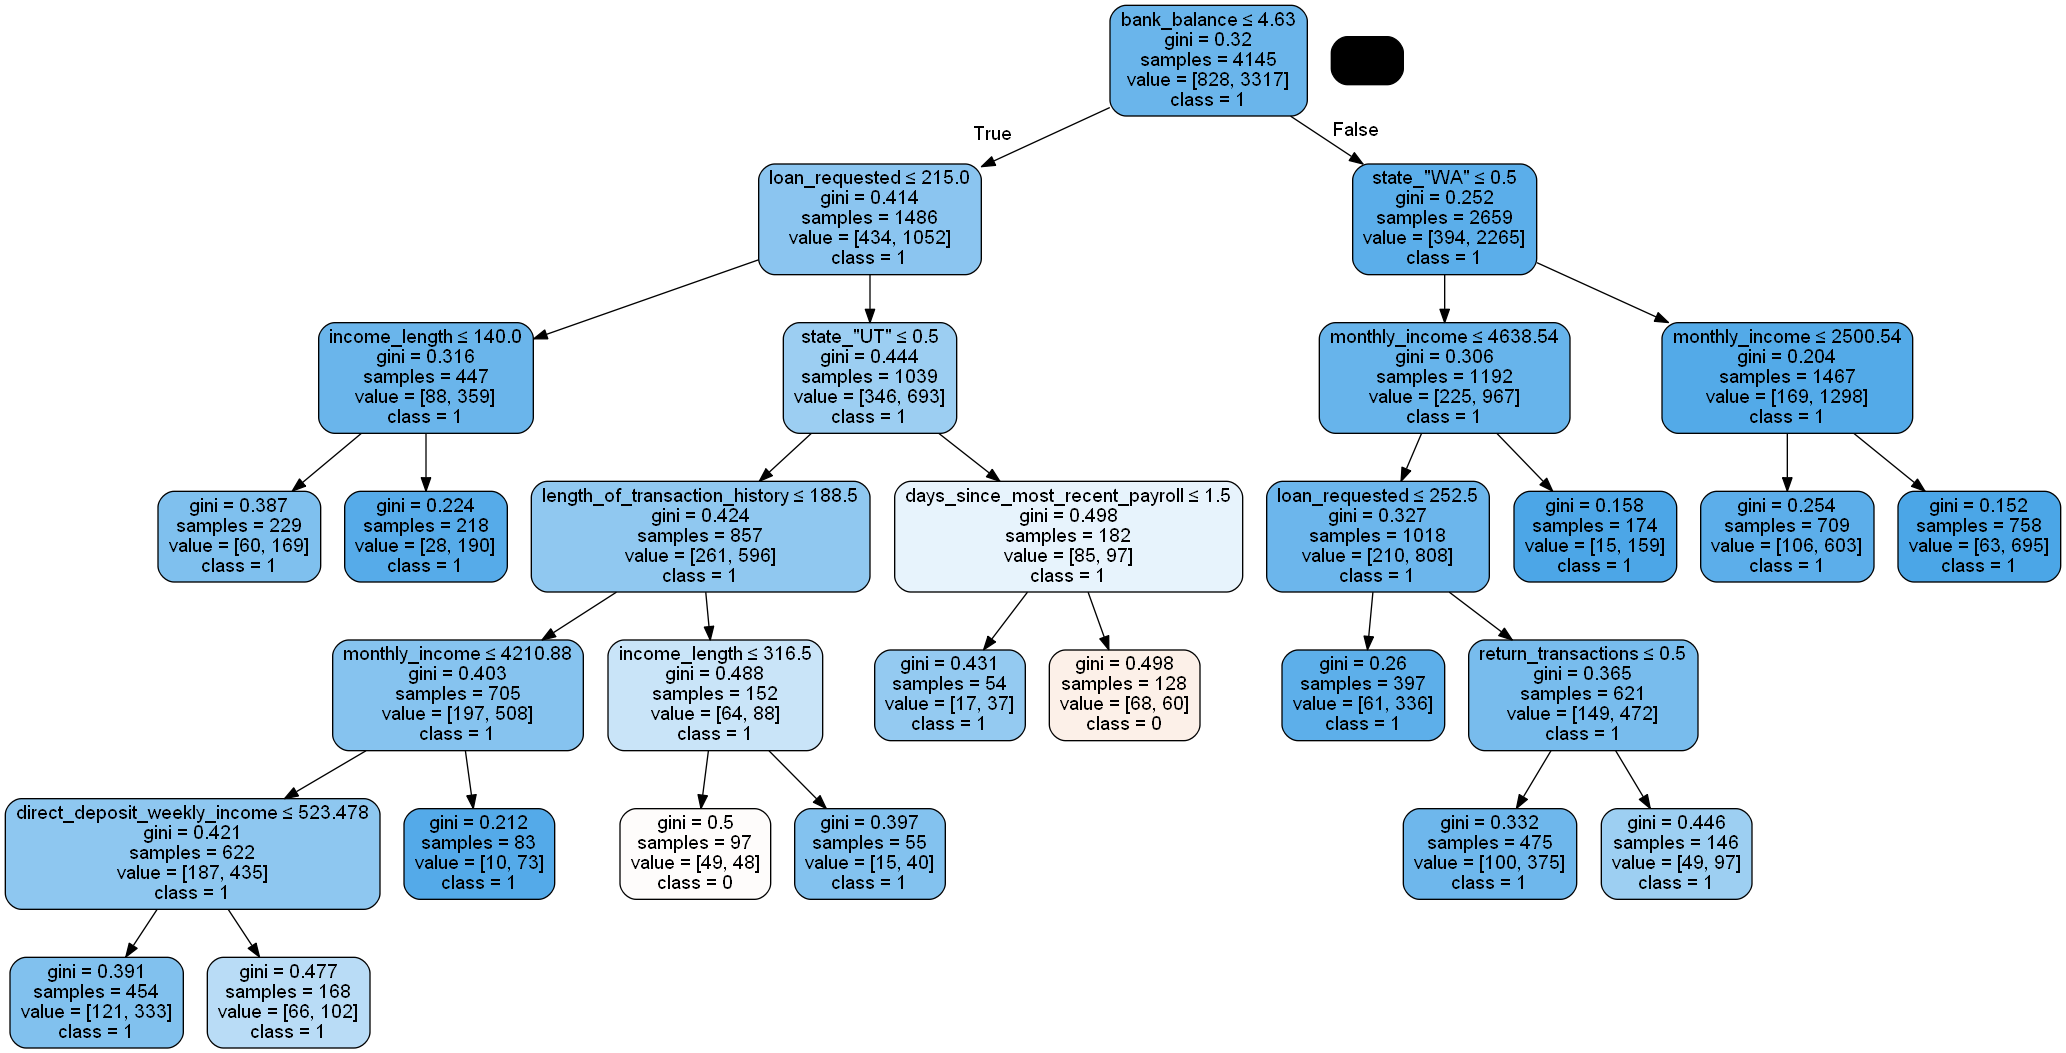

In [52]:
# fit model 
clf_tree = DecisionTreeClassifier(random_state=seed, max_depth=8, min_samples_leaf=50, max_leaf_nodes=15)
clf_tree.fit(X, y)

dot_data = StringIO()
export_graphviz(clf_tree, out_file=dot_data, 
                feature_names=X.columns.tolist(),
                class_names = ['0', '1'],
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
pltImage = Image(graph.create_png())
display(pltImage)

#graph.write_pdf("d:/ArbolitoVarImportantesPoda.pdf")

In [53]:
r = export_text(clf_tree, feature_names=list(X.columns))
print(r)

|--- bank_balance <= 4.63
|   |--- loan_requested <= 215.00
|   |   |--- income_length <= 140.00
|   |   |   |--- class: 1
|   |   |--- income_length >  140.00
|   |   |   |--- class: 1
|   |--- loan_requested >  215.00
|   |   |--- state_"UT" <= 0.50
|   |   |   |--- length_of_transaction_history <= 188.50
|   |   |   |   |--- monthly_income <= 4210.88
|   |   |   |   |   |--- direct_deposit_weekly_income <= 523.48
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- direct_deposit_weekly_income >  523.48
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- monthly_income >  4210.88
|   |   |   |   |   |--- class: 1
|   |   |   |--- length_of_transaction_history >  188.50
|   |   |   |   |--- income_length <= 316.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- income_length >  316.50
|   |   |   |   |   |--- class: 1
|   |   |--- state_"UT" >  0.50
|   |   |   |--- days_since_most_recent_payroll <= 1.50
|   |   |   |   |--- class: 1
|   |   |   |--- days_sinc

As it was seen also in the EDA, *bank_balance* seems to be one of the most important features. Monthly income and the income length also seem to be important, which makes sense as I assume income length contains a history of the number of payments the person has received: if we assume that, we can think people who have a income_length receive payments more regularly, or have received more payments. 

Even though the *state* feature had been previously been removed in the feature selection step, I will include them as the Decision Tree takes them into account in its first splits.

# Classification Model

In [54]:
# Functions
def class_report(y_pred_train, y_train, y_pred_test, y_test):
    """ 
    y_pred_train: predicted y values for train dataset
    y_train: ground truth for train dataset
    y_pred_test: predicted y values for test dataset
    y_test: ground truth for test dataset

    Returns: classification reports for train and test
    """
    print('TRAIN Classification Report')
    print('-----------------------------------------------')
    print(classification_report(y_train, y_pred_train))
    print('TEST Classification Report')
    print('-----------------------------------------------')
    print(classification_report(y_test, y_pred_test))

def metrics_class(y_pred_train, y_proba_train, y_train, y_pred_test, y_proba_test, y_test):
    """ 
    y_pred_train: model binary train prediction
    y_proba_train: model train probability prediction
    y_train : model true train target values
    y_pred_test: model binary test prediction
    y_proba_train: model  probability test prediction
    y_test : model true test target values

    Returns: dataframe  with Accuracy, Precision, Recall, F1, AUC for train and test predictions
    """
    for i in [y_pred_train, y_proba_train, y_train, y_pred_test, y_proba_test, y_test]:
        i = pd.Series(i).reset_index(drop=True).copy()

    fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_proba_train)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    ## Results
    train_accuracy = round(accuracy_score(y_train, y_pred_train), 2)
    train_precision = round(precision_score(y_train, y_pred_train), 2)
    train_recall = round(recall_score(y_train, y_pred_train), 2)
    train_f1 = round(f1_score(y_train, y_pred_train), 2)

    test_accuracy = round(accuracy_score(y_test, y_pred_test), 2)
    test_precision = round(precision_score(y_test, y_pred_test), 2)
    test_recall = round(recall_score(y_test, y_pred_test), 2)
    test_f1 = round(f1_score(y_test, y_pred_test), 2)

    train_results = pd.concat([pd.Series(train_accuracy), pd.Series(train_precision), pd.Series(train_recall),
                               pd.Series(train_f1), pd.Series(roc_auc_train)], axis=1)

    test_results = pd.concat([pd.Series(test_accuracy), pd.Series(test_precision), pd.Series(test_recall),
                              pd.Series(test_f1), pd.Series(roc_auc_test)], axis=1)

    results = train_results.append(test_results)
    results.columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    results.index = ['Train', 'Test']
#    display(results)

    ## ROC Curve
    # Train
    sns.set(rc={'figure.figsize':(5,5)})
    plt.title('TRAIN: ROC Curve')
    plt.plot(fpr_train, tpr_train, 'b', label = 'AUC = %0.2f' % roc_auc_train)
    plt.legend(loc = 'lower right')
    plt.plot([-0.01, 1.01], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return results

def feature_importance(model, X_train, top_features):
    """ 
    model: model from which you want to get the feature importance
    X_train : train set used to train the model
    top_features: number of features you want to see in the graph

    Returns: feature importance graph
    """
    plt.figure(figsize = (8,8))
    feat_importances = pd.DataFrame({'columns': X_train.columns, 
                            'importance': model.feature_importances_}).sort_values('importance',
                                                                                       ascending=False)
    sns.set_context("paper", rc={"font.size":10, "xtick.labelsize":12,"ytick.labelsize":12, "axes.labelsize":10}) 
    sns.barplot(x="importance", y="columns", data = feat_importances.iloc[:top_features,:])
    plt.show()
    
def plot_calibration_curve(est, name, fig_index, x_train, y_train, x_test, y_test):
    """ 
    est: fitted model
    name: model name in string (eg: 'XGBoost')
    fig_index: 1
    x_train : model train set
    y_train: train set target values
    x_test : model test set
    y_test: test set target values

    Returns: calibration curve plots of the original fitted model and said model with
    isotonic and sigmoid transformations, and a random forest model
    """
    from sklearn.ensemble import RandomForestClassifier
    #matplotlib.use('Agg')

    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Random Forest with no calibration as baseline
    rnf = RandomForestClassifier()

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(rnf, 'Random Forest'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(x_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(x_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y_test.max())

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

# Train test split

In [55]:
# keeping only columns selected by model and state dummy features
cols_to_drop = cols_del_rf[cols_del_rf.keep == False]['col'].tolist()[:-7]
X_feat_sel = X.loc[:,~X.columns.isin(cols_to_drop)]

X_train, X_test, y_train, y_test = train_test_split(X_feat_sel, y, test_size=0.2, random_state=seed)

## Random Forest

In [56]:
# Train with original dataset
rfc = RandomForestClassifier(random_state=seed, n_estimators=100, max_depth=10)
rf_mdl = rfc.fit(X_train, y_train)

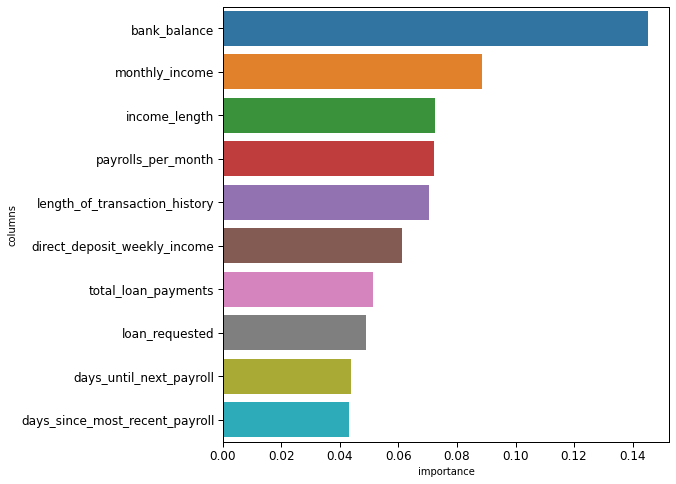

In [57]:
feature_importance(rf_mdl, X_train, 10)

## Metrics

In [160]:
scoring=['accuracy','precision_macro','recall_macro']
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) #Define evaluation procedure 

scores_ori = cross_validate(rfc, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_ori['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_ori['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_ori['test_recall_macro']))
print('')

Mean Accuracy: 0.8026
Mean Precision: 0.6839
Mean Recall: 0.5099



TRAIN Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.26      0.41       661
           1       0.84      1.00      0.92      2655

    accuracy                           0.85      3316
   macro avg       0.92      0.63      0.67      3316
weighted avg       0.88      0.85      0.82      3316

TEST Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.02      0.05       167
           1       0.80      1.00      0.89       662

    accuracy                           0.80       829
   macro avg       0.73      0.51      0.47       829
weighted avg       0.77      0.80      0.72       829



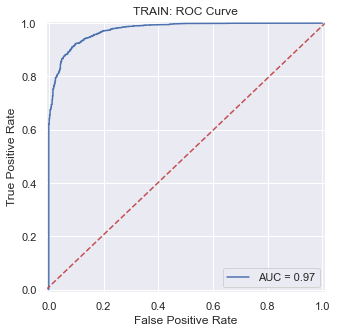

,Accuracy,Precision,Recall,F1,AUC
Train,0.85,0.84,1.0,0.92,0.974723
Test,0.80,0.80,1.0,0.89,0.652545


In [198]:
y_pred_train_rf = rf_mdl.predict(X_train)
y_pred_test_rf = rf_mdl.predict(X_test)
y_proba_train_rf = rf_mdl.predict_proba(X_train)[:,1]
y_proba_test_rf = rf_mdl.predict_proba(X_test)[:,1]

class_report(y_pred_train_rf, y_train, y_pred_test_rf, y_test)
metrics_class(y_pred_train_rf, y_proba_train_rf, y_train, y_pred_test_rf, y_proba_test_rf, y_test)

## Grid Search

In [168]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Create the random grid
parameter_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)], # Num trees in random forest
    'max_features': ['auto', 'sqrt'], # Num of features to consider at every split
    'max_depth': max_depth,
    'min_samples_split': [2, 5, 10], # Min number of samples required to split a node
    'min_samples_leaf': [1, 2, 4], # Min number of samples required at each leaf node
    'bootstrap': [True, False] # Method of selecting samples for training each tree
}

rf_random = RandomizedSearchCV(estimator = rfc, 
                               param_distributions = parameter_grid,
                               n_iter = 100, 
                               cv = folds, 
                               verbose=2, 
                               random_state=seed, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Anaconda3\envs\possible\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.80398063 0.80247279 0.80458395 0.8045844  0.8009654  0.80066374
 0.80367942 0.80397972 0.80277445 0.80247279 0.80488561 0.8009654
 0.80428229 0.80217204 0.80247233 0.80217204 0.80367897 0.80307611
 0.80398063 0.80398199 0.80277399 0.80428183 0.80428183 0.80066374
 0.80217204 0.80186947 0.80398108 0.80307565 0.80367851 0.80367897
 0.80337731 0.80458395 0.80307565 0.80367942 0.80307565 0.80337686
 0.80337686 0.80156826 0.80428229 0.80397972 0.80398108 0.80458304
 0.8006642  0.80367942 0.8009654  0.80337731 0.80398063 0.80458395
 0.80277399 0.80307701 0.80187038 0.80458395 0.80367897 0.80307565
 0.80397972 0.8033764  0.8009654  0.8045844  0.80307611 0.80307565
 0.80307474 0.80428229 0.80277399 0.80518726 0.80187038 0.80337731
 0.80458304 0.80428138 0.80217204 0.80367897 0.80307611 0.80367897
 0.80217158 0.80066374 0.80307565 0.80277399 0.80307

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': False}

In [58]:
# Train model with best params
rfc_gs = RandomForestClassifier(random_state=seed, 
                                n_estimators = 1600,
                                min_samples_split = 10,
                                min_samples_leaf = 1,
                                max_features = 'auto',
                                max_depth = 10,
                                bootstrap = False)
rf_gs_mdl = rfc_gs.fit(X_train, y_train)

### Metrics after grid search

TRAIN Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.26      0.41       661
           1       0.84      1.00      0.92      2655

    accuracy                           0.85      3316
   macro avg       0.92      0.63      0.66      3316
weighted avg       0.88      0.85      0.81      3316

TEST Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.05      0.09       167
           1       0.81      0.99      0.89       662

    accuracy                           0.80       829
   macro avg       0.74      0.52      0.49       829
weighted avg       0.78      0.80      0.73       829



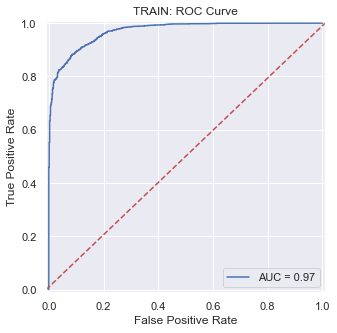

,Accuracy,Precision,Recall,F1,AUC
Train,0.85,0.84,1.00,0.92,0.969870
Test,0.80,0.81,0.99,0.89,0.663626


In [59]:
y_pred_train_rf_gs = rf_gs_mdl.predict(X_train)
y_pred_test_rf_gs = rf_gs_mdl.predict(X_test)
y_proba_train_rf_gs = rf_gs_mdl.predict_proba(X_train)[:,1]
y_proba_test_rf_gs = rf_gs_mdl.predict_proba(X_test)[:,1]

class_report(y_pred_train_rf_gs, y_train, y_pred_test_rf_gs, y_test)
metrics_class(y_pred_train_rf_gs, y_proba_train_rf_gs, y_train, y_pred_test_rf_gs, y_proba_test_rf_gs, y_test)

When I used the original max depth as it appeared in the grid search result, the model was greatly overfitting. Because of this, I decided to add some regularization and reduce the max_depth to the original value. Here we can see there is still a gap between the train and test results, but it is not as big.  

#### Feature importance

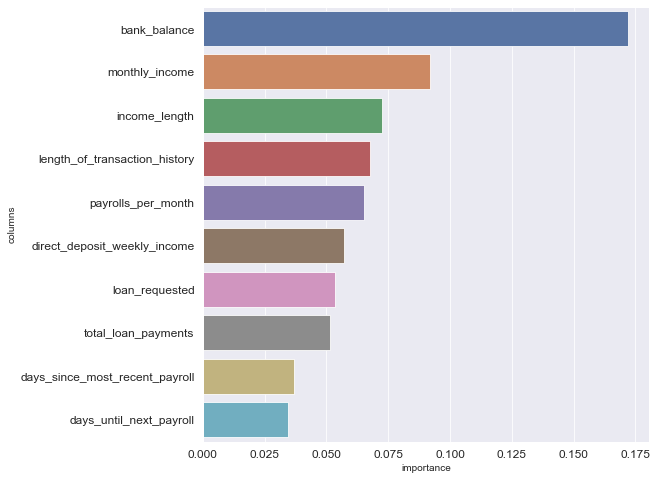

In [60]:
feature_importance(rf_gs_mdl, X_train, 10)

## XGBoost

In [61]:
xgb = xgboost.XGBClassifier(objective = 'binary:logistic',
                                     n_estimators= 800,
                                     max_depth= 5,
                                     scale_pos_weight = 1.1,
                                     learning_rate= 0.1,
                                     colsample_bytree = 0.7,
                                     subsample = 0.6,
                                     gamma = 5,
                                     use_label_encoder=False, 
                                     seed = seed)

# Original DF
model_xgb = xgb.fit(X_train, y_train, eval_metric="auc") #, eval_set=watchlist, verbose=True)

## Feature Importance

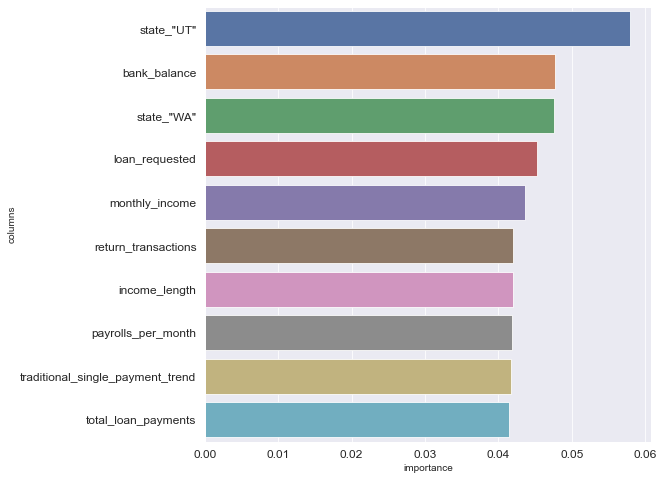

In [62]:
feature_importance(model_xgb, X_train, 10)

## Metrics

In [63]:
scoring=['accuracy','precision_macro','recall_macro']
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) #Define evaluation procedure 

scores_ori = cross_validate(model_xgb, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(scores_ori['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(scores_ori['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(scores_ori['test_recall_macro']))
print('')

Mean Accuracy: 0.7943
Mean Precision: 0.6313
Mean Recall: 0.5423



TRAIN Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.46      0.62       661
           1       0.88      1.00      0.94      2655

    accuracy                           0.89      3316
   macro avg       0.93      0.73      0.78      3316
weighted avg       0.90      0.89      0.87      3316

TEST Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.38      0.13      0.19       167
           1       0.81      0.95      0.87       662

    accuracy                           0.78       829
   macro avg       0.60      0.54      0.53       829
weighted avg       0.72      0.78      0.74       829



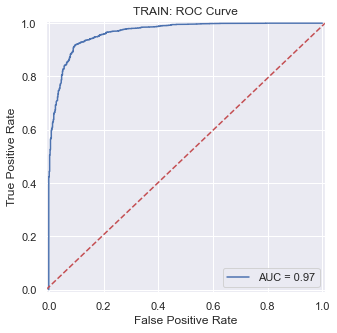

,Accuracy,Precision,Recall,F1,AUC
Train,0.89,0.88,1.00,0.94,0.965507
Test,0.78,0.81,0.95,0.87,0.633528


In [64]:
y_pred_train_xgb = model_xgb.predict(X_train)
y_pred_test_xgb = model_xgb.predict(X_test)
y_proba_train_xgb = model_xgb.predict_proba(X_train)[:,1]
y_proba_test_xgb = model_xgb.predict_proba(X_test)[:,1]

class_report(y_pred_train_xgb, y_train, y_pred_test_xgb, y_test)
metrics_class(y_pred_train_xgb, y_proba_train_xgb, y_train, y_pred_test_xgb, y_proba_test_xgb, y_test)

## Grid Search

In [65]:
clf_xgb = xgboost.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

clf = RandomizedSearchCV(clf_xgb, 
                         random_state=seed,
                         param_distributions = param_dist,
                         cv = folds,  
                         n_iter = 5, 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

clf.fit(X_train, y_train)
clf.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:04:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'colsample_bytree': 0.7865717597645278,
 'learning_rate': 0.040523511861634144,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 417,
 'subsample': 0.4034095007874714}

In [66]:
xgb_gs = xgboost.XGBClassifier(objective = 'binary:logistic',
                               eval_metric = 'logloss',
                                 n_estimators= 279,
                                 max_depth= 5,
                                 scale_pos_weight = 1.1,
                                 learning_rate= 0.08,
                                 colsample_bytree = 0.7,
                                 subsample = 0.43,
                                 min_child_weight= 1,
                                 seed = seed)

xgb_gs_mdl = xgb_gs.fit(X_train, y_train, eval_metric="auc")

### Metrics after grid search

TRAIN Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.67      0.80       661
           1       0.92      1.00      0.96      2655

    accuracy                           0.93      3316
   macro avg       0.96      0.84      0.88      3316
weighted avg       0.94      0.93      0.93      3316

TEST Classification Report
-----------------------------------------------
              precision    recall  f1-score   support

           0       0.35      0.11      0.17       167
           1       0.81      0.95      0.87       662

    accuracy                           0.78       829
   macro avg       0.58      0.53      0.52       829
weighted avg       0.72      0.78      0.73       829



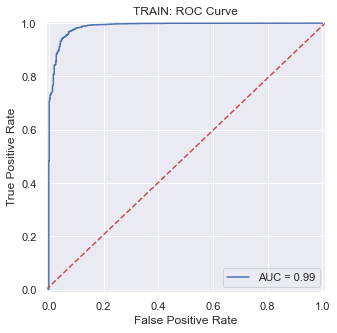

,Accuracy,Precision,Recall,F1,AUC
Train,0.93,0.92,1.00,0.96,0.988263
Test,0.78,0.81,0.95,0.87,0.629597


In [67]:
y_pred_train_xgb_gs = xgb_gs_mdl.predict(X_train)
y_pred_test_xgb_gs = xgb_gs_mdl.predict(X_test)
y_proba_train_xgb_gs = xgb_gs_mdl.predict_proba(X_train)[:,1]
y_proba_test_xgb_gs = xgb_gs_mdl.predict_proba(X_test)[:,1]

class_report(y_pred_train_xgb_gs, y_train, y_pred_test_xgb_gs, y_test)
metrics_class(y_pred_train_xgb_gs, y_proba_train_xgb_gs, y_train, y_pred_test_xgb_gs, y_proba_test_xgb_gs, y_test)

It seems that after grid search, the results in the test set are actually worse for this model.  

# Model Selection

In this case, I will chose the *Random Forest* model. Because the goal is to correctly identify those individuals who are performing poorly, the metric I will use to compare the models is the precision for the 0 values (poorly performing applicants). 

On the other hand, the features deemed relevant by the RF model seem to be more in line with the general idea of the data that the EDA gave. 

Because of these reasons, I will use this model to obtain the SHAP values and see how the features are impacting the target.

## Calibration curve

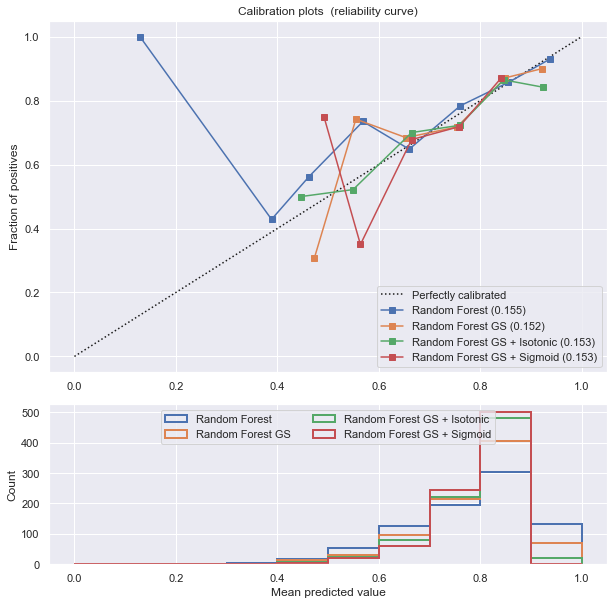

In [68]:
plot_calibration_curve(rf_gs_mdl, "Random Forest GS", 1, X_train[sorted(X_train.columns)], y_train, 
                                X_test[sorted(X_test.columns)], y_test)

To use the score of the model as a probabilty, it is necessary first to evaluate if the score is aligned to a probability of ocurrence. To do this, we will use a RF model as baseline, the trained and optimized Random Forest model and 2 calibrations: Random Forest + Isotonic and Random Forest + Sigmoid.

The X axis in the graph represents the score predicted by the model. The Y axis represents the fraction of positive values (the probability) observed in the target.
If the model was perfectly calibrated, its curve would match the dotted 45° line, and a score of 0.6 would correspond to a probability of 60%.

The metric associated to each model in the graph legend is the Brier score, which measures the efectiveness of probabilistic predictions.
The best model will be that which minimizes the Brier score.

We can see that the model could be improved by an Isotonic calibration. This means that if the model were to be used to predict, it would first have to be calibrated. As for now I will use it to see the importance of the features, I will not perform this step.

# SHAP Values

SHAP values are used to see how different features affect the prediction. They show how much a given feature changed our prediction (compared to if we made that prediction at some baseline value of that feature).

In [76]:
explainer_rf = shap.TreeExplainer(rf_gs_mdl)
shap_values_tot_rf = explainer_rf.shap_values(X_test[sorted(X_test.columns)])

Each point represents the value of that feature for that observation. The point's color shows whether the feature's value was high or low (colors closer to hot pink indicate a higher value, colors closer to blue, a lower one), and its location in the horizontal line shows that feature's impact in the model output for the class that is being evaluated.

Ej: a pink point located to the left means that feature had a higher value, and that increased the proability that that observation would correspond to that category.

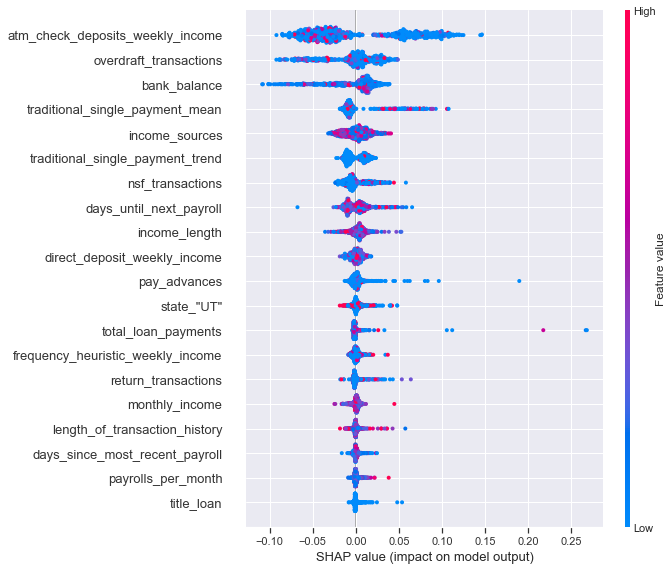

In [77]:
shap.summary_plot(shap_values_tot_rf[0], X_test)

As I am setting the index in the summary plot to 0, as there is one array for each of the possible outcomes, and this corresponds to the 0 value from the target feature. 

We can see that there are many features where the impact is not so clearly separated, with the exception of for instance the number of: 

- *pay_advances*: here, we can see that the lower the number of pay advances, the higher the probability to land in this category. 
- *total_loan_payments*: the lower the number of total loan payments, the higher the probability of landing in this category.
- *atm_checks_deposits_weekly_income*: the lower the value, the more likely it is the applicant has a poor performance. 
- *length_of_transaction_history* seems to have a positive relationship with the target value.

A higher *traditional_single_payment_mean* also seems to increase the probability, whiche also makes sense if we asume this feature is the mean of the traditional single payment loans the applicant has: if the person needs to pay more from the other loans they have, it's more likely they will not pay the current loan.    

# Possible future improvements

- Because of time constraints, I've used the features as they appear, but it could be useful to perform some feature engineering to the features corresponding to the loans and show them as a percentage of the person's income (assuming these features represent the amount the applicant pays in these loans per month)

- Some of the features could be split into bins to see if this clears up the relations we see in the SHAP graph.